# Train Simple Image Classifier

Task: Train a simple image classifier using cross-entropy loss

## Setup

In [1]:
from fastai.vision.all import *
from fastbook import *

#matplotlib.rc('image', cmap='Greys')

import sys
if sys.platform == "darwin":
    # https://stackoverflow.com/a/64855500/69707
    import os
    os.environ['OMP_NUM_THREADS'] = '1'

Load up the MNIST dataset. It has 10 digits.

In [2]:
path = untar_data(URLs.MNIST)

In [3]:
path

Path('/Users/ka37/.fastai/data/mnist_png')

In [77]:
set_seed(0)
num_imgs_per = 500
items = L([
    p
    for s in ['training', 'testing']
    for digit in range(10)
    for p in (path/s/str(digit)).ls().shuffle()[:num_imgs_per]
])

In [78]:
block = DataBlock(
    blocks=(ImageBlock(PILImageBW), CategoryBlock),
    #get_y=lambda x: int(parent_label(x)),
    get_y = parent_label,
    splitter=GrandparentSplitter(train_name='training', valid_name="testing"),
)
dataloaders = block.dataloaders(items, bs=16)
images, labels = dataloaders.one_batch()

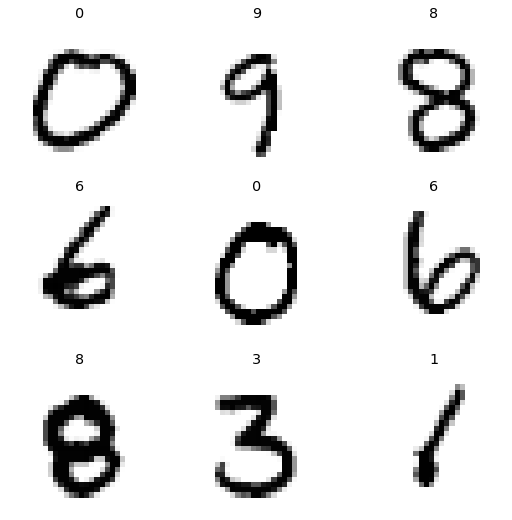

In [79]:
dataloaders.train.show_batch()

In [80]:
dataloaders.train.vocab

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

## Task



In [81]:
linear_1 = nn.Linear(in_features=784, out_features=10, bias=False)
#relu_layer = nn.ReLU()
#linear_2 = nn.Linear(in_features=30, out_features=10)

Then we put them together in sequence.

In [82]:
simple_net = nn.Sequential(
    nn.Flatten(),
    linear_1,
    #relu_layer,
    #linear_2
)

In [83]:
images, labels = dataloaders.train.one_batch()

In [84]:
images.shape

torch.Size([16, 1, 28, 28])

In [85]:
logits = simple_net(images)
logits.shape

torch.Size([16, 10])

In [86]:
TensorImageBW.register_func(F.cross_entropy, TensorImageBW, TensorCategory)

In [87]:
F.cross_entropy(logits, labels, reduction='none')

TensorImageBW([2.5593, 2.1114, 2.2406, 2.3652, 2.3240, 2.0326, 2.2824, 2.3135, 2.6814, 2.4579, 2.3630, 2.5342, 2.3509, 2.5255, 2.1803, 2.4751], grad_fn=<AliasBackward0>)

In [88]:
-np.log(.1)

2.3025850929940455

In [93]:
learning_rate = 0.01
losses = []
for i in range(10):
    for images, labels in dataloaders.train:
        logits = simple_net(images)
        loss = F.cross_entropy(logits, labels) # automatically takes the mean
        loss.backward()
        linear_1.weight.data -= learning_rate * linear_1.weight.grad
        #linear_1.bias.data -= learning_rate * linear_1.bias.grad
        simple_net.zero_grad()
        losses.append(loss.item())

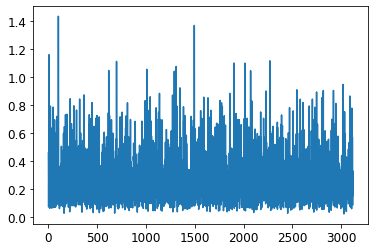

In [94]:
plt.plot(losses)

In [91]:
linear_1.weight.shape

torch.Size([10, 784])

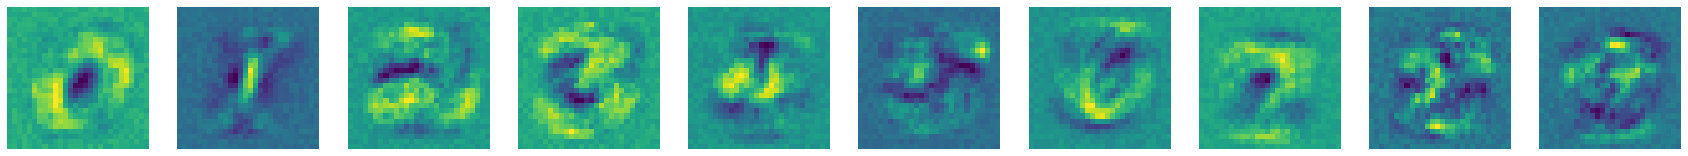

In [92]:
show_images(linear_1.weight.data.view((10, 28, 28)))